Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()


In [107]:
# ========================================
# Step 1. define data transform
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

print("Set up data transforms.")

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),
        
        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
    ]),
}
data_transforms = selected_transforms


Set up data transforms.


In [119]:
# ========================================
# Step 2. define and load data
# ========================================
print("Create dataset and dataloader")

# data location
book_data_dir = "/home/kcho/clab_data/"
set_types = ['train', 'val', 'test']

# test books are currently arbitrarily set
test_books = set(["Albin", "Dryden"])

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])

# Create a dict of datasets for each book
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}

# create a dict of dataloaders, book_data_loaders['Albin']['train']
book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                          batch_size=5,
                                                          shuffle=True, # make sure you shuffle the data
                                                          num_workers=1)
                          for t in set_types}
                     for b in books_in_data}



Create dataset and dataloader


(1, 28, 28)
(28, 28)


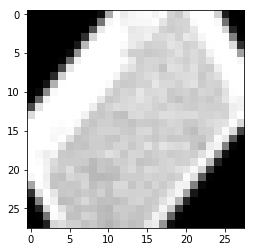

In [120]:
# ========================================
# Check your data to make sure it is correct
# ========================================

for data in book_data_loaders['Defoe']['train']:
    # get the inputs
    inputs, labels = data

    # plot to verify the input is correct
    input1 = inputs[0].numpy()
    print(input1.shape)
    input1 = np.swapaxes(input1,0,2).squeeze()
    print(input1.shape)
    plt.imshow(input1,cmap='gray')
    
    break

In [121]:
# ========================================
# Step 3. define model structure
# ========================================
from lib.playground.utee import selector

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        model_annotation.model=torch.nn.Sequential(*removed)
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [122]:
# ========================================
# Step 4. define the training process
# ========================================

def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):
    # parameter instantiation
    time_begin = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0   
    val_acc_loss = 0.0
    epoch_acc_dict = {"train": {}, "val" : {}}

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        confusion_matrix = tnt.meter.ConfusionMeter(2)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            for book in data_loaders[phase]:
                
                # Iterate over data.
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    print(labels)
                    fdsf

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects / dataset_sizes[phase]

            epoch_loss = running_loss / count
            epoch_acc = running_corrects / count
        
            epoch_acc_dict[phase][epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Print confusion matrix
            print(confusion_matrix.conf)
            print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # store most recent val_loss
            if phase == 'val':
                val_acc_loss = (1.0 - epoch_acc)
                print("val_acc_loss = " + str(val_acc_loss))

                        # save each epoch's model
#             weights_path = "resnet18_half_frozen_" + str(epoch + 1) + "epochs_transfer-state.pt"
#             torch.save(model_resnet18.state_dict(), weights_path)
#             print("saved epoch " + str(epoch + 1) + " model state (weights) to " + weights_path)
#             print("ran epoch " + str(epoch + 1))
        
        
        # Extra spacing
        print()
        print()
        
        # Include early stopping criteria check at end of epoch
        if (early_stopping is not None) and early_stopping.checkStoppingCriteria(val_acc_loss):
            print("Stopping after epoch " + str(epoch) + " due to early stopping criteria.")
            break
        

    # calculate the training time
    time_elapsed = time.time() - begin
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_acc_dict

In [124]:
# ========================================
# Step 5. execute the train process
# ========================================

# get the model
model = create_model_architecture()

# train parameters
num_training_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
earlyStoppingCriteria = EarlyStopping(min_delta = 1e-4, patience=5)

# other parameters
all_epoch_scores = {"train" : {}, "val" : {}}
cross_val_loaders = {}


# leave-one-book-out cross validation
for val_book in books_in_data:
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])    
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}

    # train
    trained_model_weights, epoch_scores = train(model,
                                                criterion,
                                                optimizer,
                                                cross_val_loaders,
                                                num_epochs=num_training_epochs,
                                                early_stopping = earlyStoppingCriteria)

    # testing for memory management
    #torch.cuda.empty_cache()


print("training complete")

using pretrained mnist model
Building and initializing mnist parameters
Epoch 0/49
----------
tensor([ 1,  1,  1,  0,  0], device='cuda:0')


NameError: global name 'fdsf' is not defined

In [ ]:
# ========================================
# Step 4. define the training process
# ========================================

def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):   
    # parameter instantiation
    time_begin = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0   
    val_acc_loss = 0.0
    epoch_acc_dict = {"train": {}, "val" : {}}

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # looping parameters
            running_loss = 0.0
            running_corrects = 0
            count = 0
            confusion_matrix = tnt.meter.ConfusionMeter(2)

            # Iterate over each book
            for book in data_loaders[phase]:
                
                # Iterate over data.
                for data in data_loaders[phase][book]:
                    # get the inputs
                    inputs, labels = data
                    
                    count += len(inputs)
                    
                    # wrap them in Variable
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    # Use adam instead of sgd so you don't need to worry about the learning rate changes
                    optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects / dataset_sizes[phase]

            epoch_loss = running_loss / count
            epoch_acc = running_corrects / count
        
            epoch_acc_dict[phase][epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Print confusion matrix
            print(confusion_matrix.conf)
            print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # store most recent val_loss
            if phase == 'val':
                val_acc_loss = (1.0 - epoch_acc)
                print("val_acc_loss = " + str(val_acc_loss))

                        # save each epoch's model
#             weights_path = "resnet18_half_frozen_" + str(epoch + 1) + "epochs_transfer-state.pt"
#             torch.save(model_resnet18.state_dict(), weights_path)
#             print("saved epoch " + str(epoch + 1) + " model state (weights) to " + weights_path)
#             print("ran epoch " + str(epoch + 1))
        
        
        # Extra spacing
        print()
        print()
        
        # Include early stopping criteria check at end of epoch
        if (early_stopping is not None) and early_stopping.checkStoppingCriteria(val_acc_loss):
            print("Stopping after epoch " + str(epoch) + " due to early stopping criteria.")
            break
        

    # calculate the training time
    time_elapsed = time.time() - begin
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_acc_dict

In [ ]:
# Average scores over the books for each epoch
ave_val_scores = {t : {} for t in all_epoch_scores}
for t in all_epoch_scores:
    for epoch in range(num_training_epochs):
        count = 0
        cum = 0
        for book in all_epoch_scores[t]:
            if epoch in all_epoch_scores[t][book]:
                cum += all_epoch_scores[t][book][epoch]
                count += 1
        if count != 0:
            ave_val_scores[t][epoch] = (cum/count)

print(ave_val_scores)

best_epochs = {t : max(ave_val_scores[t], key=ave_val_scores[t].get) for t in ave_val_scores}
print(best_epochs)

In [ ]:
weights_path = "resnet18_half_frozen_5epochs_transfer-state.pt"
torch.save(model_resnet18.state_dict(), weights_path)
print("saved model state (weights) to " + weights_path)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

visualize_model(model_resnet18)
print("visualizing model")

In [ ]:
print("running on testing dataset")
model_resnet18.train(False)  # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0

criterion = nn.CrossEntropyLoss()

# Iterate over data.
for data in dataloaders["test"]:
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    # zero the parameter gradients
#     optimizer.zero_grad()

    # forward
    outputs = model_resnet18(inputs)
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)

    # backward + optimize only if in training phase
#     if phase == 'train':
#         loss.backward()
#         optimizer.step()

    # statistics
    running_loss += loss.data[0] * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / dataset_sizes["test"]
epoch_acc = running_corrects / dataset_sizes["test"]

print('{} Loss: {:.4f} Acc: {:.4f}'.format(
    "test", epoch_loss, epoch_acc))